## Introduction

Sentiment analysis is a natural language processing (NLP) technique used to determine the emotional tone of text.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

## Data Loading and Preprocessing

In [5]:
df_train = pd.read_csv("dataset/Amazon_Reviews_train.csv")
df_test = pd.read_csv("dataset/Amazon_Reviews_test.csv")

for index, row in df_train.iloc[5:8].iterrows():
    print(f"{row['label']} - {row['text']}")

1 - an absolute masterpiece: I am quite sure any of you actually taking the time to read this have played the game at least once, and heard at least a few of the tracks here. And whether you were aware of it or not, Mitsuda's music contributed greatly to the mood of every single minute of the whole game.Composed of 3 CDs and quite a few songs (I haven't an exact count), all of which are heart-rendering and impressively remarkable, this soundtrack is one I assure you you will not forget. It has everything for every listener -- from fast-paced and energetic (Dancing the Tokage or Termina Home), to slower and more haunting (Dragon God), to purely beautifully composed (Time's Scar), to even some fantastic vocals (Radical Dreamers).This is one of the best videogame soundtracks out there, and surely Mitsuda's best ever. ^_^
0 - Buyer beware: This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family an

In [6]:
import nltk
from nltk.corpus import stopwords

# Download NLTK resources
nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers - Sentences may contain numbers which are not useful for our sentiment analysis
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fam2064\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
for index, row in df_train.iterrows():
    df_train.at[index, 'cleaned_text'] = clean_text(row['text'])

for index, row in df_test.iterrows():
    df_test.at[index, 'cleaned_text'] = clean_text(row['text'])

df_train = df_train.copy()
df_test = df_test.copy()
df_train.drop('text', axis=1, inplace=True)
df_test.drop('text', axis=1, inplace=True)
df_train.rename(columns={'cleaned_text': 'text'}, inplace=True)
df_test.rename(columns={'cleaned_text': 'text'}, inplace=True)

for index, row in df_train.iloc[5:8].iterrows():
    print(f"{row['label']} - {row['text']}")

1 - absolute masterpiece quite sure actually taking time read played game least heard least tracks whether aware mitsudas music contributed greatly mood every single minute whole gamecomposed cds quite songs havent exact count heartrendering impressively remarkable soundtrack one assure forget everything every listener fastpaced energetic dancing tokage termina home slower haunting dragon god purely beautifully composed times scar even fantastic vocals radical dreamersthis one best videogame soundtracks surely mitsudas best ever _
0 - buyer beware selfpublished book want know whyread paragraphs star reviews must written ms haddons family friendsor perhaps cant imagine anyone reading whole thingi spent evening book friend hysterics reading bits pieces one another definitely bad enough entered kind worst book contest cant believe amazon even sells kind thing maybe offer th grade term paper kill mockingbirda book quite sure ms haddon never heard anyway unless mood send book someone jokest

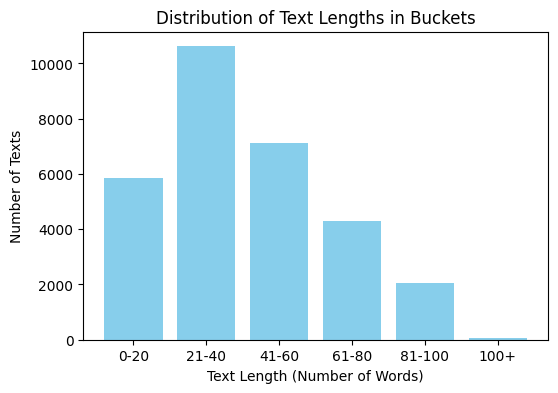

In [8]:
# Step 1: Calculate the length of each text
df_train["text_length"] = df_train["text"].apply(lambda x: len(x.split()))  # Split by spaces to count words

# Step 2: Define the buckets
buckets = [0, 20, 40, 60, 80, 100, float('inf')]  # Last bucket is 200+
bucket_labels = ["0-20", "21-40", "41-60", "61-80", "81-100", "100+"]

# Step 3: Count the number of texts in each bucket
df_train["bucket"] = pd.cut(df_train["text_length"], bins=buckets, labels=bucket_labels, right=False)
bucket_counts = df_train["bucket"].value_counts().sort_index()

# Step 4: Plot the results
plt.figure(figsize=(6, 4))
plt.bar(bucket_counts.index, bucket_counts.values, color='skyblue')
plt.xlabel("Text Length (Number of Words)")
plt.ylabel("Number of Texts")
plt.title("Distribution of Text Lengths in Buckets")
plt.show()

## Configurations

In [9]:
from types import SimpleNamespace

# Create a SimpleNamespace for configurations
configs = SimpleNamespace(
    max_len=128,          # Maximum sequence length for tokenization  ------ 128
    batch_size=32,        # Batch size for training
    learning_rate=5e-4,   # Learning rate for optimizer # 1e-3
    num_epochs=10,        # Number of training epochs
    dropout=0.4,          # Dropout rate for the model
    patience=2,           # Patience for early stopping
    random_seed=42,       # Random seed for reproducibility
    embedding_dim = 128,
    hidden_dim = 256,
    output_dim = 2,
    model_name="bert-base-uncased"  # Pre-trained model name
)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

cuda NVIDIA GeForce RTX 2080 Super with Max-Q Design


## Dataset and DataLoader Creation

In [11]:
# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(configs.model_name)

In [12]:
# Custom Dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [13]:
# Collate Function
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    return input_ids.to(device), attention_mask.to(device), labels.to(device)

In [14]:
# Create DataLoaders
df_train_texts = df_train['text'].tolist()
df_train_labels = df_train['label'].tolist()
df_test_texts = df_test['text'].tolist()
df_test_labels = df_test['label'].tolist()

train_dataset = SentimentDataset(df_train_texts, df_train_labels, tokenizer, configs.max_len)
test_dataset = SentimentDataset(df_test_texts, df_test_labels, tokenizer, configs.max_len)

train_loader = DataLoader(train_dataset, batch_size=configs.batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=configs.batch_size, shuffle=False, collate_fn=collate_fn)

## LSTM Model Definition

In [15]:
# Define the BiLSTM with Attention model
class BiLSTMWithAttention(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, vocab_size, num_layers=2, dropout=configs.dropout):
        super(BiLSTMWithAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, 
                             bidirectional=True, batch_first=True, dropout=dropout)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        attn_weights = torch.softmax(self.attention(lstm_out).squeeze(-1), dim=1)
        context = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)
        context = self.batch_norm(context)
        output = self.fc(self.dropout(context))
        return output

## Training and Evaluation

In [16]:
# Define training pipeline
def train_model(model, train_loader, val_loader, num_epochs=configs.num_epochs, lr=configs.learning_rate, weight_decay=1e-5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    best_val_acc = 0
    best_model_state = None
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct, total_samples = 0, 0, 0
        
        # for inputs, masks, labels in train_loader:
        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            inputs, masks, labels = batch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            # Clip gradients to a maximum norm (e.g., 1.0) to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item() * inputs.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()
            total_samples += inputs.size(0)
        
        train_loss = total_loss / total_samples
        train_accuracy = total_correct / total_samples
        
        # Validation phase
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        
        print(f'Epoch {epoch+1}: | Train Loss={train_loss:.4f} \
              | Train Acc={train_accuracy:.4f} \
              | Val Acc={val_accuracy:.4f}')
        
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_state = model.state_dict()
            epochs_without_improvement = 0  # Reset counter
        else: # Early stopping
            epochs_without_improvement += 1
            if epochs_without_improvement >= configs.patience:
                print(f"Early stopping triggered. No improvement in validation accuracy for {configs.patience} epochs.")
                break
        
        scheduler.step()
    
    # Save best model
    if best_model_state:
        torch.save(best_model_state, "best_lstm_model.pth")
        print("Best model saved.")


def evaluate_model(model, data_loader, criterion, device):
    # Set the model to evaluation mode to disable dropout
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    
    with torch.no_grad():
        for inputs, masks, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()
            total_samples += inputs.size(0)
            
    val_loss = total_loss / total_samples
    val_accuracy = total_correct / total_samples
    return val_loss, val_accuracy

In [17]:
# Initialize model
vocab_size = tokenizer.vocab_size

model = BiLSTMWithAttention(configs.embedding_dim, configs.hidden_dim, configs.output_dim, vocab_size).to(device)

# Train the model
train_model(model, train_loader, test_loader)

Epoch 1/10: 100%|██████████| 938/938 [00:48<00:00, 19.44it/s]


Epoch 1: | Train Loss=0.4878               | Train Acc=0.7613               | Val Acc=0.8215


Epoch 2/10: 100%|██████████| 938/938 [00:48<00:00, 19.48it/s]


Epoch 2: | Train Loss=0.3229               | Train Acc=0.8625               | Val Acc=0.8540


Epoch 3/10: 100%|██████████| 938/938 [00:52<00:00, 17.77it/s]


Epoch 3: | Train Loss=0.2473               | Train Acc=0.9011               | Val Acc=0.8622


Epoch 4/10: 100%|██████████| 938/938 [00:53<00:00, 17.50it/s]


Epoch 4: | Train Loss=0.1726               | Train Acc=0.9352               | Val Acc=0.8521


Epoch 5/10: 100%|██████████| 938/938 [00:57<00:00, 16.18it/s]


Epoch 5: | Train Loss=0.1092               | Train Acc=0.9618               | Val Acc=0.8567
Early stopping triggered. No improvement in validation accuracy for 2 epochs.
Best model saved.


## Model Loading and Prediction

In [18]:
# Load model and predict
def predict(model, tokenizer, texts):
    model.load_state_dict(torch.load("best_lstm_model.pth"))
    model.to(device)
    model.eval()
    
    cleaned_texts = []
    for text in texts:
        cleaned_texts.append(clean_text(text))

    inputs = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=configs.max_len, return_tensors='pt')
    inputs = inputs['input_ids'].to(device)
    
    with torch.no_grad():
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
    
    sentiment_labels = ["Negative", "Positive"]
    return [sentiment_labels[p] for p in predictions]

In [19]:
# Example usage
sample_texts = [
    "This product is amazing! The quality is outstanding and it exceeded all my expectations. I would definitely recommend it to anyone!",
    "Terrible product. Broke within a week of purchase. Save your money and look elsewhere.",
    "It's okay. Not great, not terrible. Does the job but nothing special.",
    "Absolutely love this! Best purchase I've made all year. The customer service was also excellent.",
    "Don't waste your time. Poor quality and overpriced. Very disappointed with this purchase."
]
predictions = predict(model, tokenizer, sample_texts)
print(predictions)

['Positive', 'Negative', 'Negative', 'Positive', 'Negative']
